## Access Diver Survey Metadata QC (Parquet)
This Jupyter notebook demonstrates how to access and plot diver_survey_metadata_qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/997c2e15-b345-438f-afac-49a4ac19be38).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/diver_survey_metadata_qc.ipynb).


In [1]:
dataset_name = "diver_survey_metadata_qc"

## Install/Update packages and Load common functions

In [ ]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

In [2]:
from DataQuery import GetAodn

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:3217: UserWarning: registration of accessor <class 'DataQuery.AODNAccessor'> under name 'aodn' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("aodn")


# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [3]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 73.5 ms, sys: 16.2 ms, total: 89.7 ms
Wall time: 8.65 s


In [4]:
aodn_dataset.dataset.partitioning.schema

timestamp: int32
polygon: string

## List unique partition values

In [5]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('timestamp')
print(list(unique_partition_value)[0:2])  # showing a subset only

['1167609600', '1104537600']
CPU times: user 8.42 ms, sys: 1.13 ms, total: 9.55 ms
Wall time: 6.93 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


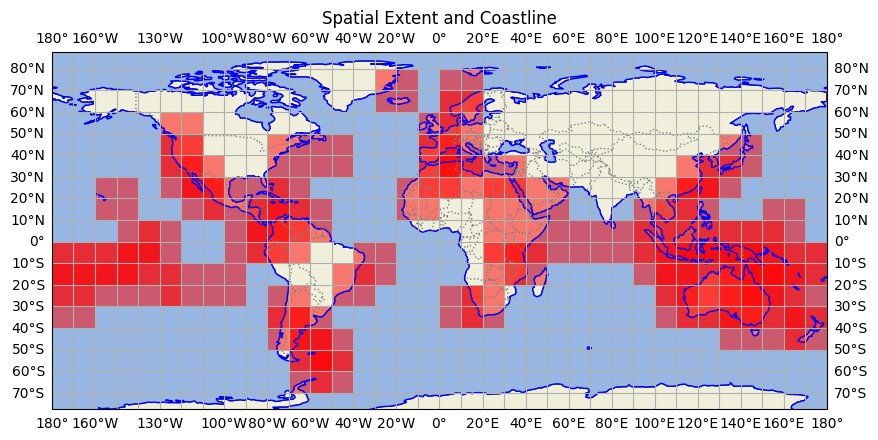

In [6]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
%%time
aodn_dataset.get_temporal_extent()

CPU times: user 101 ms, sys: 15.2 ms, total: 116 ms
Wall time: 762 ms


(Timestamp('1992-03-10 00:00:00'), Timestamp('2025-09-15 15:00:00'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [8]:
metadata = aodn_dataset.get_metadata()
metadata

2025-11-10 16:56:11,291 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/diver_survey_metadata_qc.parquet


{'survey_id': {'type': 'int32'},
 'country': {'type': 'string'},
 'area': {'type': 'string'},
 'location': {'type': 'string'},
 'site_code': {'type': 'string'},
 'site_name': {'type': 'string'},
 'latitude': {'type': 'float32'},
 'longitude': {'type': 'float32'},
 'depth': {'type': 'float32'},
 'survey_date': {'type': 'string'},
 'latest_surveydate_for_site': {'type': 'bool'},
 'has_pq_scores_in_db': {'type': 'bool'},
 'has_rugosity_scores_in_db': {'type': 'bool'},
 'has_pqs_catalogued_in_db': {'type': 'bool'},
 'visibility': {'type': 'float32'},
 'hour': {'type': 'string'},
 'direction': {'type': 'string'},
 'survey_latitude': {'type': 'string'},
 'survey_longitude': {'type': 'string'},
 'avg_rugosity': {'type': 'float32'},
 'max_rugosity': {'type': 'float32'},
 'surface': {'type': 'string'},
 'program': {'type': 'string'},
 'pq_zip_url': {'type': 'string'},
 'old_site_codes': {'type': 'string'},
 'methods': {'type': 'string'},
 'geom': {'type': 'string'},
 'filename': {'type': 'strin

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [9]:
%%time
df = aodn_dataset.get_data(date_start='2015-12-01', 
                           date_end='2019-01-01',
                           lat_min=-34, 
                           lat_max=-31, 
                           lon_min=151, 
                           lon_max=153,
                           lat_varname="latitude",
                           lon_varname="longitude",
                           )

df.info()

2025-11-10 16:56:11,892 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/diver_survey_metadata_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   survey_id                   371 non-null    int32         
 1   country                     371 non-null    object        
 2   area                        371 non-null    object        
 3   location                    371 non-null    object        
 4   site_code                   371 non-null    object        
 5   site_name                   371 non-null    object        
 6   latitude                    371 non-null    float32       
 7   longitude                   371 non-null    float32       
 8   depth                       371 non-null    float32       
 9   survey_date                 371 non-null    object        
 10  latest_surveydate_for_site  371 non-null    bool          
 11  has_pq_scores_in_db         371 non-null    bool          

In [10]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/aodn_metadata-uuid_997c2e15-b345-438f-afac-49a4ac19be38_diver_survey_metadata_qc_data-hash_a4d60044.csv.zip

In [11]:
df

,survey_id,country,area,location,site_code,site_name,latitude,longitude,depth,survey_date,...,surface,program,pq_zip_url,old_site_codes,methods,geom,filename,TIME,timestamp,polygon
0,912345923,Australia,New South Wales,Port Stephens,PS13,Pipeline,-32.720001,152.139999,7.5,2015-12-24,...,None,RLS,http://rls.tpac.org.au/pq/912345923/zip/,"tnsw12,tnsw1","1, 12, 2",0101000020E6100000000000E07A04634000000000295C...,ep_survey_list_public_data.csv,2015-12-24 00:00:00,1420070400,0103000000010000000500000000000000008061400000...
1,912346114,Australia,New South Wales,Cod Grounds,CG1,Nth of Pinnacles (662),-31.680000,152.910004,27.0,2016-04-21,...,None,RLS,http://rls.tpac.org.au/pq/912346114/zip,"8CG_349,1CG_349","1, 13, 2",0101000020E6100000000000C01E1D63400000008014AE...,ep_survey_list_public_data.csv,2016-04-21 09:00:00,1451606400,0103000000010000000500000000000000008061400000...
2,912346126,Australia,New South Wales,Cod Grounds,CG1,Nth of Pinnacles (662),-31.680000,152.910004,26.0,2016-04-21,...,None,RLS,http://rls.tpac.org.au/pq/912346126/zip,"8CG_349,1CG_349","0, 1, 13, 2",0101000020E6100000000000C01E1D63400000008014AE...,ep_survey_list_public_data.csv,2016-04-21 09:00:00,1451606400,0103000000010000000500000000000000008061400000...
3,912346120,Australia,New South Wales,Cod Grounds,CG10,Steves Bommie (668),-31.680000,152.910004,36.0,2016-04-21,...,None,RLS,http://rls.tpac.org.au/pq/912346120/zip,10CG_357,"1, 13, 2",0101000020E6100000000000C01E1D63400000008014AE...,ep_survey_list_public_data.csv,2016-04-21 10:00:00,1451606400,0103000000010000000500000000000000008061400000...
4,912346117,Australia,New South Wales,Cod Grounds,CG11,SE lumps (66A),-31.680000,152.910004,30.0,2016-04-19,...,None,RLS,http://rls.tpac.org.au/pq/912346117/zip,11CG_358,"0, 1, 13, 2",0101000020E6100000000000C01E1D63400000008014AE...,ep_survey_list_public_data.csv,2016-04-19 11:00:00,1451606400,0103000000010000000500000000000000008061400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,912350788,Australia,New South Wales,Sydney,SYD61,Cape Banks - Cruwee Cove,-34.000000,151.250000,4.5,2018-03-30,...,None,RLS,http://rls.tpac.org.au/pq/912350788/zip,None,"1, 2",0101000020E61000000000000000E86240000000000000...,ep_survey_list_public_data.csv,2018-03-30 11:00:00,1514764800,0103000000010000000500000000000000008061400000...
367,912350789,Australia,New South Wales,Sydney,SYD61,Cape Banks - Cruwee Cove,-34.000000,151.250000,6.0,2018-03-30,...,None,RLS,http://rls.tpac.org.au/pq/912350789/zip,None,"0, 1, 2",0101000020E61000000000000000E86240000000000000...,ep_survey_list_public_data.csv,2018-03-30 11:00:00,1514764800,0103000000010000000500000000000000008061400000...
368,912350787,Australia,New South Wales,Sydney,SYD61,Cape Banks - Cruwee Cove,-34.000000,151.250000,5.0,2018-03-30,...,None,RLS,http://rls.tpac.org.au/pq/912350787/zip,None,"1, 2",0101000020E61000000000000000E86240000000000000...,ep_survey_list_public_data.csv,2018-03-30 11:00:00,1514764800,0103000000010000000500000000000000008061400000...
369,912350786,Australia,New South Wales,Sydney,SYD61,Cape Banks - Cruwee Cove,-34.000000,151.250000,4.0,2018-03-30,...,None,RLS,None,None,"1, 2",0101000020E61000000000000000E86240000000000000...,ep_survey_list_public_data.csv,2018-03-30 11:00:00,1514764800,0103000000010000000500000000000000008061400000...


## Survey Map

In [12]:
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=7)
marker_cluster = MarkerCluster().add_to(m)

for _, row in df.iterrows():
    popup = folium.Popup(
        f"<b>Site:</b> {row['site_name']}<br>"
        f"<b>Location:</b> {row['location']}<br>"
        f"<b>Depth:</b> {row['depth']} m<br>"
        f"<b>Date:</b> {row['survey_date']}<br>"
        f"<b>Program:</b> {row['program']}<br>"
        f"<b>PQ scores:</b> {row['has_pq_scores_in_db']}<br>"
        f"<b>Rugosity:</b> {row['has_rugosity_scores_in_db']}",
        max_width=300
    )
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=6,
        color="darkblue",
        fill=True,
        fill_opacity=0.6,
        popup=popup
    ).add_to(marker_cluster)

m


In [13]:
from folium.plugins import HeatMap

m = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=7)
HeatMap(df[["latitude", "longitude"]].values.tolist(), radius=10, blur=15).add_to(m)
m
